# Data Extraction


The following commands will fetch the CSV files from its remote server, download the zipped files and unzip it.

#The following command downloads all 2019 files from  citibike amazon S3 server using http protocol
!curl -O "https://s3.amazonaws.com/tripdata/2019[03-06]-citibike-tripdata.csv.zip"
!curl -O "https://s3.amazonaws.com/tripdata/2020[03-06]-citibike-tripdata.csv.zip"
#The following command extract all files from the the specified zip archive to the current directoy
!unzip '*.zip'
!rm *.zip

In [1]:
#import the librairies
import glob #using glob to read multiple files
import datetime #convert seconds or nanoseconds to DateTime 
import pandas as pd #import the pandas library and aliasing as pd
import numpy as np #Shape manipulation and Fourier transformation
import seaborn as sns #visualizing the data 
from matplotlib import pyplot as plt  #visualizing the data 
%matplotlib inline 

sns.set(style="whitegrid") # helps to keep the grid from competing with lines that represent data

## Scaling the dataset

The files have large datasets that consume an excessive amount of RAM. This can cause code to fail due to insufficient memory and crash the application. 

Several columns are unnecessary in this analysis. Skipping over these columns directly before reading in the data can save a lot of memory.

There are columns in the CSV that takes up more space than they need to. By default when pandas load CSV files, it assigns numerical columns to int64 type. We’re going to specify the data types we want pandas to use reading in the columns.

The following commands reduce the data frame memory by simply selecting the appropriate data types and loding less columns.

In [2]:
filenames = sorted(glob.glob('*.csv'))#Get file names


#Shrinking down to the columns I'm interested in 
cols = ["tripduration","starttime","start station name","end station name","bikeid","usertype","birth year","gender"]

#reducing the memory usage that this columns
col_type={'birth year':'int16', 'gender':'int8'}


# Loop through file names and read the data
dfs = []
for file in filenames:
    print('Reading ' + file)
    #dfs.append(pd.read_csv(file))
    df = pd.read_csv(file, usecols = cols, dtype = col_type)
    dfs.append(df)

Reading 201903-citibike-tripdata.csv
Reading 201904-citibike-tripdata.csv
Reading 201905-citibike-tripdata.csv
Reading 201906-citibike-tripdata.csv
Reading 202003-citibike-tripdata.csv
Reading 202004-citibike-tripdata.csv
Reading 202005-citibike-tripdata.csv
Reading 202006-citibike-tripdata.csv


In [3]:
df = pd.concat(dfs, ignore_index=True)

In [4]:
# Checks out the total data
rows = df.shape[0]
print(str(rows) + " Rows")

12265369 Rows


Let's take a look on the data we are working with

In [5]:
df.head(4)

,tripduration,starttime,start station name,end station name,bikeid,usertype,birth year,gender
0,1463,2019-03-01 00:00:16.0970,Fulton St & Broadway,Greenwich St & W Houston St,35618,Subscriber,1989,1
1,285,2019-03-01 00:00:32.3850,E 4 St & 2 Ave,E 2 St & Avenue C,31113,Subscriber,1980,1
2,686,2019-03-01 00:00:47.7970,E 33 St & 5 Ave,6 Ave & Spring St,19617,Subscriber,1987,1
3,442,2019-03-01 00:01:01.2090,6 Ave & Spring St,Bayard St & Baxter St,27086,Subscriber,1987,2


# Data Cleaning

In [6]:
#the null() and sum() gives the total numbers of missing values of each columns
missing_v = df.isnull().sum()
missing_v

tripduration           0
starttime              0
start station name    10
end station name      10
bikeid                 0
usertype               0
birth year             0
gender                 0
dtype: int64

In [7]:
#drop rows with NaN values
d_rows = df.dropna(how='any')

print('old dataframe total :' , df.shape)
print('new dataframe shape total :', d_rows.shape)
print("Dropping rows containing Na values in any columns resulted in almost 37 reduction.")

old dataframe total : (12265369, 8)
new dataframe shape total : (12265359, 8)
Dropping rows containing Na values in any columns resulted in almost 37 reduction.


In [8]:
#rename columns to a more recognisable sets of labels
df.columns=['tripduration','starttime','start_station_name','end_station_name','bikdeid','usertype','birth_year','gender']

#Transform the values for gender
df.loc[df['gender'] == 2, 'gender'] = 'F'
df.loc[df['gender'] == 1, 'gender'] = 'M'
df.loc[df['gender'] == 0, 'gender'] = 'NaN'

# Calculate the age of the person considering that the year is 2020
df['age'] = 2019 - df['birth_year']

#categorise age column
df['age_group']=pd.cut(df.age,bins = [16,30,50,90], labels =['16-29','30-49','50-89'])



#calculate the weekday from the startime
df['weekday'] = pd.to_datetime(df["starttime"]).dt.strftime('%A')


# Calculate the month from the startime
df['month'] = pd.to_datetime(df["starttime"]).dt.strftime('%B')


# Calculate the year from the startime
df['year'] = pd.to_datetime(df["starttime"]).dt.strftime('%Y')



# convert the timestamp column to datetime
df['time'] = pd.to_datetime(df['starttime'])
# extract hour from the timestamp column to create an time_hour column
df['time_hour'] = df['time'].dt.hour

df['period'] = (df['time'].dt.hour % 24 + 4) // 4
df['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [9]:
# Transform the durantion of the trip from seconds to hr:m:s
df['tripduration']=pd.to_datetime(df.tripduration, unit='s').dt.strftime('%H:%M:%S')

#drop rows for  trip durations that are  less than 5 min and more than 20hr
df = df.drop(df[df.tripduration <'00:05:00'].index)
df = df.drop(df[df.tripduration >'10:00:00'].index)


# Check out the total data
rows = df.shape[0]
print(str(rows) + " Rows")
print("The returned dataframe only contains  ")

10379666 Rows
The returned dataframe only contains  


The following commands drop any trips that lasted less than 5 min. This decision is made based on the assumption of how long it would take a rider to realise a bike isn't working properly and come back to the station and takes a new one. Any trips longer than 10hr is also dropped it. This is based on the assumption that riders can never make a trip longer than 10hr.

In [10]:
df.head(3)

,tripduration,starttime,start_station_name,end_station_name,bikdeid,usertype,birth_year,gender,age,age_group,weekday,month,year,time,time_hour,period
0,00:24:23,2019-03-01 00:00:16.0970,Fulton St & Broadway,Greenwich St & W Houston St,35618,Subscriber,1989,M,30,16-29,Friday,March,2019,2019-03-01 00:00:16.097,0,Late Night
2,00:11:26,2019-03-01 00:00:47.7970,E 33 St & 5 Ave,6 Ave & Spring St,19617,Subscriber,1987,M,32,30-49,Friday,March,2019,2019-03-01 00:00:47.797,0,Late Night
3,00:07:22,2019-03-01 00:01:01.2090,6 Ave & Spring St,Bayard St & Baxter St,27086,Subscriber,1987,F,32,30-49,Friday,March,2019,2019-03-01 00:01:01.209,0,Late Night


# Data Analysis

## Did CitiBike suffer a drastic ridership reduction?

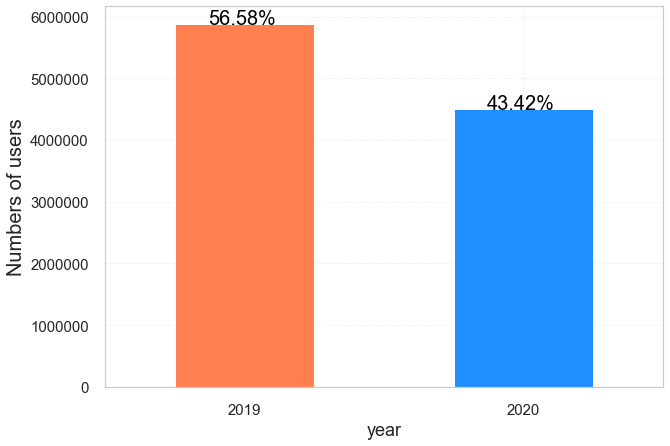

In [24]:
ax = df['year'].value_counts().plot(kind='bar', figsize=(10,7),color=['coral','dodgerblue'], fontsize=15);

ax.set_alpha(0.8)
ax.set_title("", fontsize=20)
ax.set_ylabel("Numbers of users", fontsize=20);
ax.set_xlabel("year", fontsize=18);

plt.xticks(rotation=0,horizontalalignment="center")


# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 10) 
ax.yaxis.set_tick_params(pad = 10) 

total = df.shape[0]    
    
# Add x, y gridlines 
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2) 


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.12, i.get_height(), \
            str(round((i.get_height())*100/total, 2))+'%', fontsize=20,
                color='black',)

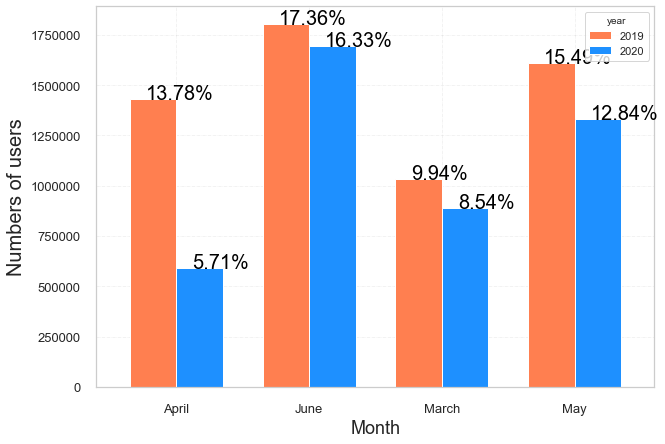

In [23]:
ax = df.groupby(['month', 'year']).size().unstack().plot(kind='bar', figsize=(10,7),
                                        color=['coral','dodgerblue'], fontsize=13, width=0.7 )

ax.set_alpha(0.8)
ax.set_title("", fontsize=20)
ax.set_ylabel("Numbers of users", fontsize=20);
ax.set_xlabel("Month", fontsize=18);

plt.xticks(rotation=0,horizontalalignment="center")


# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 10) 
ax.yaxis.set_tick_params(pad = 10) 

total = df.shape[0]    
    
# Add x, y gridlines 
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2) 


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.12, i.get_height(), \
            str(round((i.get_height())*100/total, 2))+'%', fontsize=20,
                color='black',)




## Have people been travelling less and following the Stay-at-home orders?

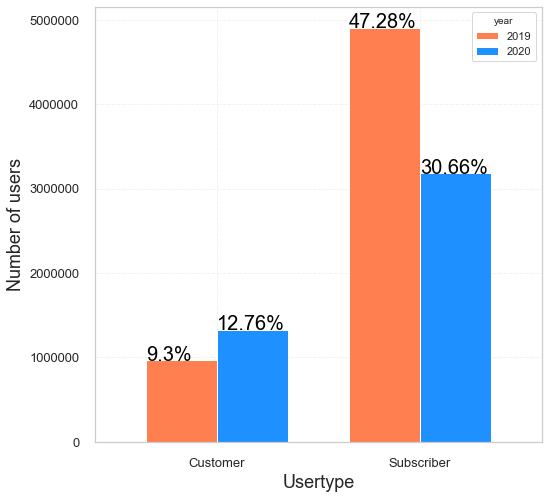

In [25]:
ax = df.groupby(['usertype', 'year']).size().unstack().plot(kind='bar', figsize=(10,7),
                                        color=['coral','dodgerblue'], fontsize=13, width=0.7 )

ax.set_alpha(0.8)
ax.set_title("", fontsize=18)
ax.set_ylabel("Number of users", fontsize=18);
ax.set_xlabel("Usertype", fontsize=18);

plt.xticks(rotation=0,horizontalalignment="center")

# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 10) 
ax.yaxis.set_tick_params(pad = 10) 

total = df.shape[0]  
    
# Add x, y gridlines 
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height())*100/total, 2))+'%', fontsize=20,
                color='black')

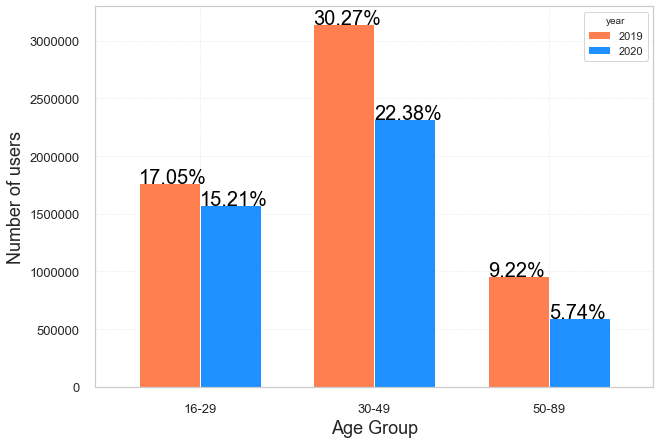

In [32]:
ax = df.groupby(['age_group', 'year']).size().unstack().plot(kind='bar', figsize=(10,7),
                                        color=['coral','dodgerblue'], fontsize=13, width=0.7 )

ax.set_alpha(0.8)
ax.set_title("", fontsize=18)
ax.set_ylabel("Number of users", fontsize=18);
ax.set_xlabel("Age Group", fontsize=18);

plt.xticks(rotation=0,horizontalalignment="center")

# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 10) 
ax.yaxis.set_tick_params(pad = 10) 

total = df.shape[0]  
    
# Add x, y gridlines 
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height())*100/total, 2))+'%', fontsize=20,
                color='black')

    


## Did the top Location that the riders visited changed?

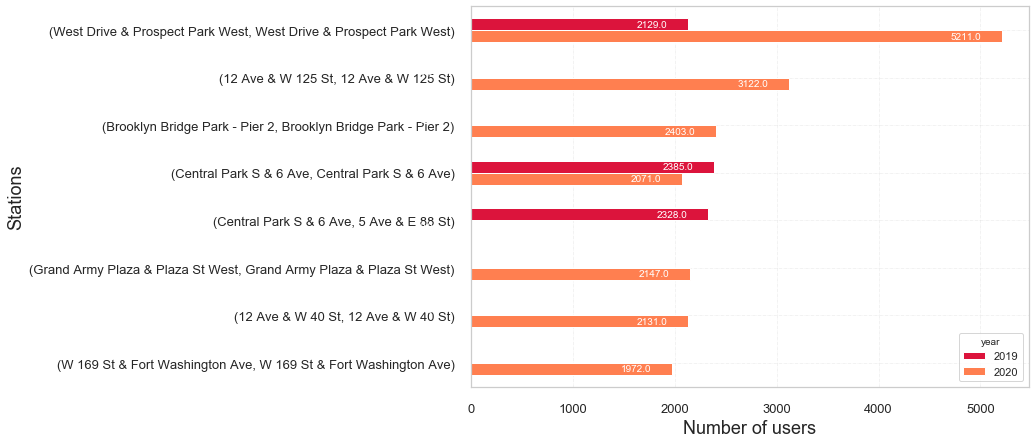

In [36]:
ax = df.groupby(['start_station_name','end_station_name','year']).size().nlargest(10).unstack().plot(kind='barh',figsize=(10,7), color=['crimson','coral'], fontsize=13)



ax.set_alpha(0.8)
ax.set_title("",fontsize=18)
ax.set_xlabel("Number of users", fontsize=18)
ax.set_ylabel("Stations", fontsize=18)


# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 10) 
ax.yaxis.set_tick_params(pad = 10) 

total= df.shape[0]
  
# Add x, y gridlines 
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)


# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()-500, i.get_y()+.18, \
            str(round((i.get_width()), 2)), fontsize=10, color='white')

    
# Show top values 
ax.invert_yaxis()  

